In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

In [18]:
import sys
sys.path.append('../src') # Add src directory to Python path
from outlier import detect_outliers_iqr, detect_outliers_zscore, winsorize_df, remove_outliers_df

In [19]:
raw_dir = '../data/raw'
processed_dir = '../data/processed'
docs_dir = '../docs' 
src_dir = '../src'
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')

In [20]:
data_path = Path(csv_path)
df_original = None
target_col = None
feature_col = None

if data_path.exists():
    df_original = pd.read_csv(data_path)
    # For the 'outliers_homework.csv' dataset, we'll analyze 'daily_return'
    # and use 'daily_return' to predict 'daily_return_2' if regression is applicable.
    target_col = 'daily_return'
    feature_col = 'daily_return_2' if 'daily_return_2' in df_original.columns else None # Use daily_return_2 as 'y' for regression
    print(f"Loaded data from {data_path}. Target column for outlier detection: '{target_col}'")
    if feature_col:
        print(f"Feature column for regression (dependent): '{feature_col}'")
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    print("Primary CSV not found. Generating fallback synthetic dataset (x, y).")
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18 # Inject extremes
    df_original = pd.DataFrame({'x': x, 'y': y})
    target_col = 'y'
    feature_col = 'x'
    print(f"Generated fallback (x, y) dataset. Target column for outlier detection: '{target_col}'")
    print(f"Feature column for regression (independent): '{feature_col}'")

df = df_original.copy() # Work with a copy

print("\nOriginal DataFrame head:")
print(df.head())

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the DataFrame. Please check data loading logic.")
if feature_col and feature_col not in df.columns:
    print(f"Warning: Feature column '{feature_col}' not found for regression.")
    feature_col = None

Loaded data from ../data/raw/outliers_homework.csv. Target column for outlier detection: 'daily_return'
Feature column for regression (dependent): 'daily_return_2'

Original DataFrame head:
         date  daily_return  daily_return_2
0  2022-01-03      0.001263        0.003834
1  2022-01-04     -0.020046       -0.009506
2  2022-01-05      0.004739       -0.000535
3  2022-01-06      0.009953        0.012539
4  2022-01-07      0.008872        0.009840


In [23]:
print("Outlier detection and handling functions are imported from src/outlier.py.")

# Apply detection using imported functions
df['outlier_iqr'] = detect_outliers_iqr(df[target_col], k=1.5)
df['outlier_zscore'] = detect_outliers_zscore(df[target_col], threshold=3.0)

print(f"Fraction of data flagged by IQR method: {df['outlier_iqr'].mean():.3f}")
print(f"Fraction of data flagged by Z-score method: {df['outlier_zscore'].mean():.3f}")

# 1. IQR filtered data (outliers removed)
df_filtered_iqr = remove_outliers_df(df, flag_columns=['outlier_iqr'], how='any')

# 2. Winsorized data
df_winsorized_data = winsorize_df(df, columns=[target_col], lower=0.05, upper=0.95)

print("\n--- Outlier Detection Summary ---")
print(f"Original dataset shape: {df.shape}")
print(f"Dataset after IQR filtering shape: {df_filtered_iqr.shape}")
print(f"Dataset after Winsorization (retains shape): {df_winsorized_data.shape}")

Outlier detection and handling functions are imported from src/outlier.py.
Fraction of data flagged by IQR method: 0.078
Fraction of data flagged by Z-score method: 0.043

--- Outlier Detection Summary ---
Original dataset shape: (115, 9)
Dataset after IQR filtering shape: (106, 9)
Dataset after Winsorization (retains shape): (115, 9)


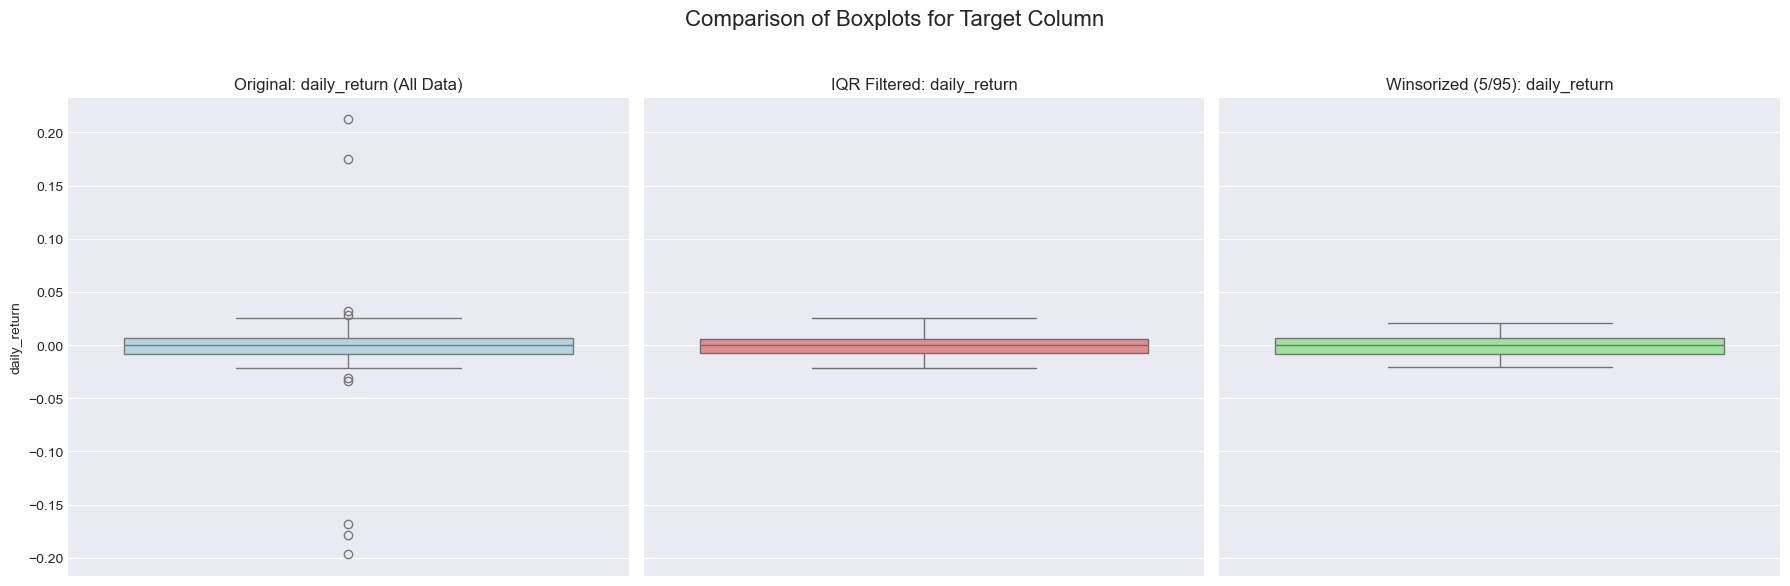

In [28]:
plt.style.use('seaborn-v0_8-darkgrid')

# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.boxplot(y=df[target_col], ax=axes[0], color='lightblue')
axes[0].set_title(f'Original: {target_col} (All Data)')
axes[0].set_ylabel(target_col)

sns.boxplot(y=df_filtered_iqr[target_col], ax=axes[1], color='lightcoral')
axes[1].set_title(f'IQR Filtered: {target_col}')
axes[1].set_ylabel('')

sns.boxplot(y=df_winsorized_data[target_col], ax=axes[2], color='lightgreen')
axes[2].set_title(f'Winsorized (5/95): {target_col}')
axes[2].set_ylabel('')

plt.suptitle('Comparison of Boxplots for Target Column', fontsize=16)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()

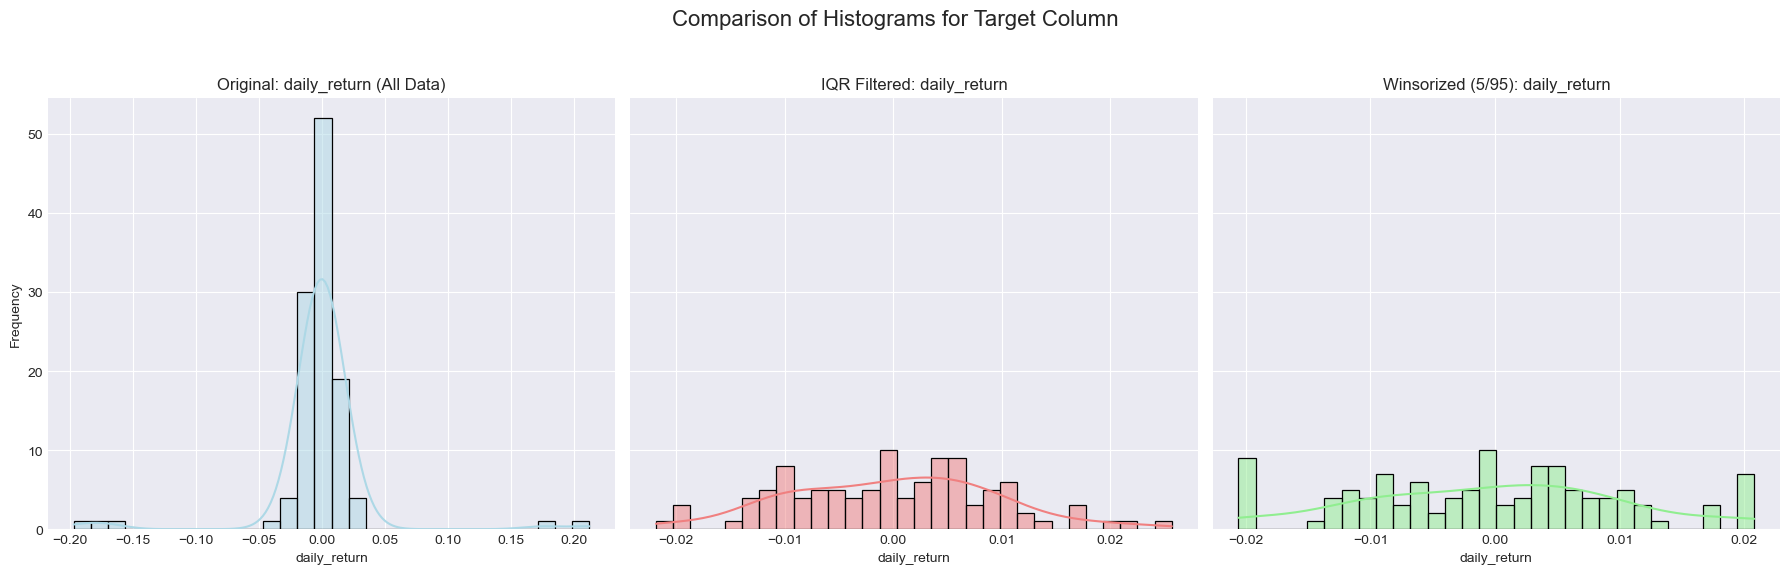

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(df[target_col], bins=30, kde=True, ax=axes[0], color='lightblue')
axes[0].set_title(f'Original: {target_col} (All Data)')
axes[0].set_xlabel(target_col)
axes[0].set_ylabel('Frequency')

sns.histplot(df_filtered_iqr[target_col], bins=30, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title(f'IQR Filtered: {target_col}')
axes[1].set_xlabel(target_col)
axes[1].set_ylabel('')

sns.histplot(df_winsorized_data[target_col], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title(f'Winsorized (5/95): {target_col}')
axes[2].set_xlabel(target_col)
axes[2].set_ylabel('')

plt.suptitle('Comparison of Histograms for Target Column', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [32]:
print(f"--- Sensitivity Analysis for '{target_col}' ---\n")

# Option A: Summary statistics comparison
print("### A. Comparison of Summary Statistics ###")
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df_filtered_iqr[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_winsorized = df_winsorized_data[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp_summary = pd.concat(
    {
        'All Data': summ_all,
        'IQR Filtered': summ_filtered,
        'Winsorized (5/95)': summ_winsorized
    }, axis=1
)
print("Summary Statistics Comparison:")
print(comp_summary.round(4).to_markdown(numalign="left", stralign="left"))

--- Sensitivity Analysis for 'daily_return' ---

### A. Comparison of Summary Statistics ###
Summary Statistics Comparison:
|        | All Data   | IQR Filtered   | Winsorized (5/95)   |
|:-------|:-----------|:---------------|:--------------------|
| mean   | -0.0014    | -0             | -0.0003             |
| median | -0.0002    | -0.0001        | -0.0002             |
| std    | 0.0406     | 0.0094         | 0.0106              |



### B. Comparison of Simple Linear Regression: 'daily_return' (independent) vs 'daily_return_2' (dependent) ###
Linear Regression Results Comparison:
|                   | slope   | intercept   | R^2    | MAE    |
|:------------------|:--------|:------------|:-------|:-------|
| All Data          | 0.6059  | 0.0002      | 0.9619 | 0.004  |
| IQR Filtered      | 0.5897  | -0          | 0.5736 | 0.0039 |
| Winsorized (5/95) | 1.4672  | -0.0003     | 0.3866 | 0.0107 |


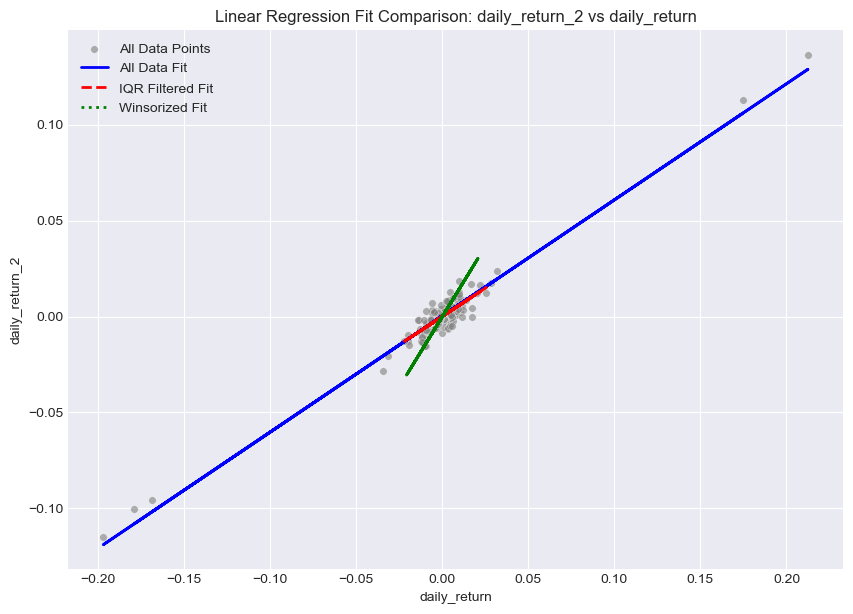

In [33]:
# Option B: Simple regression comparison (if appropriate feature column exists)
if feature_col:
    print(f"\n### B. Comparison of Simple Linear Regression: '{target_col}' (independent) vs '{feature_col}' (dependent) ###")

    # Prepare data for regression. Note: `target_col` is the independent variable (X), `feature_col` is dependent (y).
    X_all = df[[target_col]].to_numpy() 
    y_all = df[feature_col].to_numpy()
    
    # Filtered data for regression
    X_filtered = df_filtered_iqr[[target_col]].to_numpy()
    y_filtered = df_filtered_iqr[feature_col].to_numpy()

    # Winsorized data for regression
    X_winsorized = df_winsorized_data[[target_col]].to_numpy()
    y_winsorized = df_winsorized_data[feature_col].to_numpy()
    
    # Fit models
    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)
    model_winsorized = LinearRegression().fit(X_winsorized, y_winsorized)
    
    # Evaluate models
    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    r2_all = model_all.score(X_all, y_all)

    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))
    r2_flt = model_flt.score(X_filtered, y_filtered)

    mae_winsorized = mean_absolute_error(y_winsorized, model_winsorized.predict(X_winsorized))
    r2_winsorized = model_winsorized.score(X_winsorized, y_winsorized)

    regression_results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0], model_winsorized.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_, model_winsorized.intercept_],
        'R^2': [r2_all, r2_flt, r2_winsorized],
        'MAE': [mae_all, mae_flt, mae_winsorized]
    }, index=['All Data', 'IQR Filtered', 'Winsorized (5/95)'])
    
    print("Linear Regression Results Comparison:")
    print(regression_results.round(4).to_markdown(numalign="left", stralign="left"))
    
    # Visual comparison of regression fits
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=df[target_col], y=df[feature_col], label='All Data Points', alpha=0.6, color='grey', s=30)
    
    # Plot regression lines
    plt.plot(X_all, model_all.predict(X_all), color='blue', linestyle='-', linewidth=2, label='All Data Fit')
    plt.plot(X_filtered, model_flt.predict(X_filtered), color='red', linestyle='--', linewidth=2, label='IQR Filtered Fit')
    plt.plot(X_winsorized, model_winsorized.predict(X_winsorized), color='green', linestyle=':', linewidth=2, label='Winsorized Fit')
    
    plt.title(f'Linear Regression Fit Comparison: {feature_col} vs {target_col}')
    plt.xlabel(target_col)
    plt.ylabel(feature_col)
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\nSkipping regression analysis: Insufficient numeric columns for feature-target relationship.")

